In [1]:
import numpy as np
import re
import os
import random

import tensorflow as tf
import tensorflow_datasets as tfds

target_shape = (96, 96)
BATCH_SIZE = 512
images_path = os.getcwd() + "\Dataset"

In [2]:
import cv2

def preprocess_image(filename):
    """
    Load the specified file, preprocess it and
    resize it to the target shape.
    """
    img = cv2.imread(filename)
    img = cv2.resize(img, target_shape)
    return img

In [3]:
from sklearn.model_selection import train_test_split

dicImages = {}
dataset_x = []; dataset_y = []
for dirs in os.listdir(images_path):
    if(dirs != 'lfw_funneled'):
        for f in os.listdir(images_path+'\\'+dirs):
            fClass = int(re.findall('[0-9]+', f)[0])
            dataset_x.append(images_path+'\\'+dirs+'\\'+f)
            dataset_y.append(fClass)
    
dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)
    
x_train, x_val, label_train, label_val = train_test_split(dataset_x, dataset_y, test_size=0.1)

print(dataset_x.shape, dataset_y.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

del(dataset_x)
del(dataset_y)

(55270,) (55270,)
(49743,) (49743,)
(5527,) (5527,)


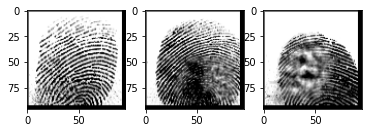

In [4]:
import matplotlib.pyplot as plt

plt.subplot(1,3,1)
plt.imshow(preprocess_image(random.choice(x_train)))

plt.subplot(1,3,2)
plt.imshow(preprocess_image(random.choice(x_train)))

plt.subplot(1,3,3)
plt.imshow(preprocess_image(random.choice(x_train)))

In [5]:
from sklearn.utils import shuffle
from imgaug import augmenters as iaa

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x, label, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.x) // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch_tmp = self.x[index*self.batch_size:(index+1)*self.batch_size]
        x1_batch = []
        for f in x1_batch_tmp: x1_batch.append(preprocess_image(f))
        x1_batch = np.array(x1_batch)
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        x1_batch = tf.keras.applications.vgg19.preprocess_input(x1_batch)
                
        return x1_batch, label_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [6]:
train_gen = DataGenerator(x_train, label_train, batch_size=BATCH_SIZE, shuffle=True)
val_gen = DataGenerator(x_val, label_val, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import Model

def Get_Model():
    vgg = tf.keras.applications.vgg19.VGG19(input_shape=target_shape+(3,), include_top=False, weights='imagenet')
    vgg.trainable = False

    flatten = layers.Flatten()(vgg.output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.Dropout(0.2)(dense1)
    #dense1 = layers.BatchNormalization()(dense1)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.Dropout(0.2)(dense2)
    #dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)
    output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output)

    return Model(vgg.input, output, name="Embedding")
    
model = Get_Model()

In [9]:
import tensorflow_addons as tfa

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tfa.losses.TripletSemiHardLoss())

history = model.fit(
    x=train_gen,
    validation_data=val_gen,
    epochs=5)

Epoch 1/5
97/97 [==============================] - 345s 3s/step - loss: 0.9817 - val_loss: 0.9716
Epoch 2/5
97/97 [==============================] - 310s 3s/step - loss: 0.9802 - val_loss: 0.9718
Epoch 3/5
97/97 [==============================] - 320s 3s/step - loss: 0.9792 - val_loss: 0.9697
Epoch 4/5
97/97 [==============================] - 320s 3s/step - loss: 0.9786 - val_loss: 0.9694
Epoch 5/5
97/97 [==============================] - 316s 3s/step - loss: 0.9775 - val_loss: 0.9681


In [10]:
model.save_weights('tripletLoss_weight.h5')

In [8]:
model.load_weights('tripletLoss_weight.h5')

In [11]:
def Test_Image(Anchor_img, Test_img):

    anchor = preprocess_image(Anchor_img)
    test = preprocess_image(Test_img)

    anchor = tf.expand_dims(anchor, 0)
    test = tf.expand_dims(test, 0)

    anchor_embedding, test_embedding = (
        model(anchor),
        model(test),
    ) # Return (1, 256) Vector = last logits from model
    
    ap_distance = tf.reduce_sum(tf.square(anchor_embedding - test_embedding), 1)
    
    return ap_distance.numpy()

def Test_Accuracy(Anchor_img):
    threshold = 0
    resTot = []
    aClass = int(re.findall('[0-9]+', Anchor_img)[0])
    
    for f in os.listdir(images_path+'/Real'):
            fClass = int(re.findall('[0-9]+', f)[0])
            if(str(f) != Anchor_img):
                res = Test_Image(images_path+'/Real/'+Anchor_img, images_path+'/Real/'+str(f))
                if(fClass == aClass): threshold += res
                resTot.append((res, fClass))
    threshold = threshold/9
    print('Threshold:', threshold)

    TP = 0; FP = 0; TN = 0; FN = 0
    for res in resTot:
        if(res[0] < threshold and res[1] == aClass): TP += 1
        elif(res[0] < threshold and res[1] != aClass): FN +=1
        elif(res[0] > threshold and res[1] == aClass): FP +=1
        elif(res[0] > threshold and res[1] != aClass): TN +=1
    accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
    
    return accuracy, FP

accuracy, FP = Test_Accuracy('1__M_Left_index_finger.BMP')
print('For class 1 there is: ' + str(accuracy) + '% accuracy and ' + str(FP) + ' False Positive')
accuracy, FP = Test_Accuracy('2__F_Left_index_finger.BMP')
print('For class 2 there is: ' + str(accuracy) + '% accuracy and ' + str(FP) + ' False Positive')

Threshold: [1.0384262]
For class 1 there is: 83.64727454575763% accuracy and 3 False Positive
Threshold: [0.9609712]
For class 2 there is: 81.01350225037505% accuracy and 3 False Positive
